## Recursive Neural Networks - LSTM


**Long Short-Term Memory** (LSTM) o redes de memoria a largo plazo, es una variación de las **Recursive Neural Networks** (RNN) que son capaces de aprender dependencias a largo plazo, especialmente en problemas de predicción de secuencias.

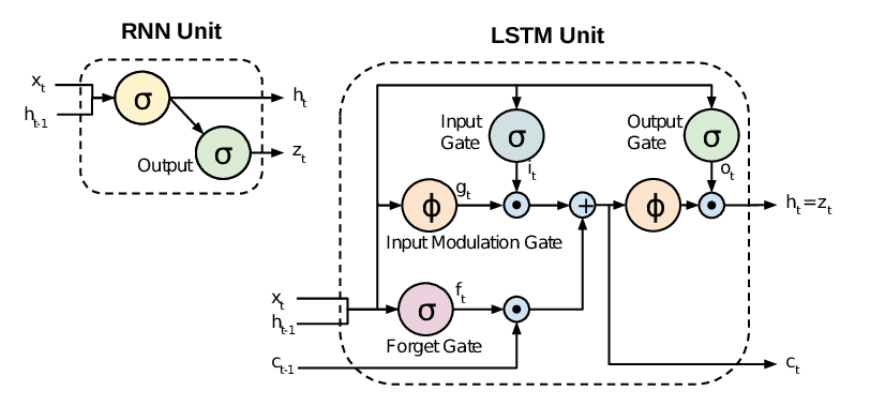

In [2]:
import numpy as np
import pandas as pd

import matplotlib # Para ver la versión
import matplotlib.pyplot as plt

import tensorflow as tf # Para ver la versión
import keras # Para ver la versión

from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.layers import Input, Dense, Flatten, Embedding, LSTM
from keras.layers import MaxPooling1D, GlobalMaxPool1D, Conv1D
from keras.models import Sequential
from keras.optimizers import Adam

import sklearn # Para ver la versión

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
# Versiones

print(f"numpy=={np.__version__}")
print(f"pandas=={pd.__version__}")
print(f"matplotlib=={matplotlib.__version__}")
print(f"tensorflow=={tf.__version__}")
print(f"keras=={keras.__version__}")
print(f"scikit-learn=={sklearn.__version__}")

# Unidades de procesamiento
print("\nUnidades de procesamiento:")
for device in tf.config.list_physical_devices():
    print(f"\t- {device.name}")

numpy==1.26.4
pandas==1.2.4
matplotlib==3.4.2
tensorflow==2.17.0
keras==3.5.0
scikit-learn==1.5.1

Unidades de procesamiento:
	- /physical_device:CPU:0


In [4]:
df = pd.read_csv("../Data/spam.csv", encoding = "ISO-8859-1")

df.head()

,label,text
0,no spam,Subject: enron methanol ; meter # : 988291\r\n...
1,no spam,"Subject: hpl nom for january 9 , 2001\r\n( see..."
2,no spam,"Subject: neon retreat\r\nho ho ho , we ' re ar..."
3,spam,"Subject: photoshop , windows , office . cheap ..."
4,no spam,Subject: re : indian springs\r\nthis deal is t...


In [7]:
import re
def eliminar_puntuacion(texto):
    texto = re.sub(r'[^\w\s]', '', texto)
    texto = texto.lower()
    return texto

df['text'] = df['text'].apply(eliminar_puntuacion)

In [8]:
df["label"] = df["label"].map({"no spam" : 0, "spam" : 1})

df

,label,text
0,0,subject enron methanol meter 988291\r\nthis...
1,0,subject hpl nom for january 9 2001\r\n see at...
2,0,subject neon retreat\r\nho ho ho we re aroun...
3,1,subject photoshop windows office cheap mai...
4,0,subject re indian springs\r\nthis deal is to ...
...,...,...
5166,0,subject put the 10 on the ft\r\nthe transport ...
5167,0,subject 3 4 2000 and following noms\r\nhpl c...
5168,0,subject calpine daily gas nomination\r\n\r\n\r...
5169,0,subject industrial worksheets for august 2000 ...


In [ ]:
df["label"] = df["label"].map({"ham" : 0, "spam" : 1})

df

### Train, Test

In [10]:
X = df["text"]
y = df["label"]

print(X.shape, y.shape)

(5171,) (5171,)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")

Train: (3619,), (3619,)
Test: (1552,), (1552,)


### Tokenizer

In [12]:
tokenizer = Tokenizer(num_words = 5_000)
tokenizer.fit_on_texts(X_train)

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

In [13]:
# print(tokenizer.word_index)

print(f"Tokens: {len(tokenizer.word_index)}")

Tokens: 47365


In [14]:
data_train = pad_sequences(sequences = sequences_train, maxlen = 500)

print(f"Train: {data_train.shape}")

Train: (3619, 500)


In [15]:
data_test = pad_sequences(sequences = sequences_test, maxlen = 500)

print(f"Test: {data_test.shape}")

Test: (1552, 500)


In [16]:
(data_train.shape[1], )

(500,)

### Model - LSTM

In [17]:
model = Sequential()

# Capa de Entrada
model.add(Input(shape = (data_train.shape[1], )))

# Embedding
model.add(Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 20))

# LSTM
model.add(LSTM(units = 15, return_sequences = True))

# Pooling
model.add(GlobalMaxPool1D())

# Capa de Salida
model.add(Dense(units = 1, activation = "sigmoid"))

model.compile(optimizer = "adam",
              loss      = "binary_crossentropy",
              metrics   = ["accuracy"])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 500, 20)        │       947,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 500, 15)        │         2,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 15)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 949,496 (3.62 MB)

 Trainable params: 949,496 (3.62 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = model.fit(x = data_train, y = y_train,
                    validation_data = (data_test, y_test), epochs = 10)

Epoch 1/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 31s 242ms/step - accuracy: 0.6464 - loss: 0.6343 - val_accuracy: 0.7603 - val_loss: 0.4744
Epoch 2/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 31s 274ms/step - accuracy: 0.8517 - loss: 0.3912 - val_accuracy: 0.7326 - val_loss: 0.5728
Epoch 3/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 35s 302ms/step - accuracy: 0.7658 - loss: 0.4990 - val_accuracy: 0.8524 - val_loss: 0.3539
Epoch 4/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 35s 307ms/step - accuracy: 0.8870 - loss: 0.3073 - val_accuracy: 0.8827 - val_loss: 0.2818
Epoch 5/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 34s 297ms/step - accuracy: 0.9192 - loss: 0.2241 - val_accuracy: 0.8963 - val_loss: 0.2353
Epoch 6/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 27s 234ms/step - accuracy: 0.9251 - loss: 0.1882 - val_accuracy: 0.9027 - val_loss: 0.2075
Epoch 7/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 29s 255ms/step - accuracy: 0.9291 - loss: 0.1594 - val_accuracy: 0.9143 - val_loss: 0.1785
Epoch 8/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 24s 214ms/step - accuracy: 0.9460 - loss: 0

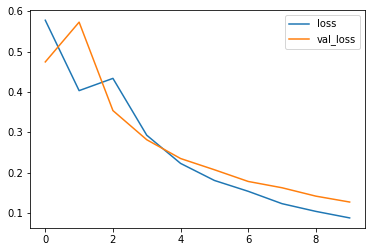

In [19]:
# loss
plt.plot(history.history["loss"], label = "loss")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.legend()
plt.show()

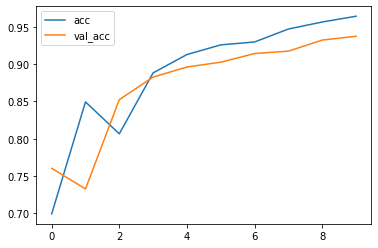

In [20]:
# accuracy
plt.plot(history.history["accuracy"], label = "acc")
plt.plot(history.history["val_accuracy"], label = "val_acc")
plt.legend()
plt.show()

In [ ]:
# Predicciones
y_hat = model.predict(data_test)
y_hat = [0 if x < 0.5 else 1 for x in y_hat]

y_hat

In [22]:
confusion_matrix(y_test, y_hat)

array([[1066,   36],
       [  61,  389]])

In [ ]:
################################################################################################################################